# Applied Data Science Capstone
This is my notebook for the capstone project. 

In [114]:
import pandas as pd
import numpy as np
#!conda install -c anaconda beautifulsoup4 -y
#!conda install -c anaconda html5lib -y
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

print(" Hello Capstone Project Course!")

 Hello Capstone Project Course!


### Scraping Wikipedia
First we set a header for our request. This makes our program look like a real browser in case Wikipedia has a blocker against scrapers. In this case an Ubuntu instance using Firefox. 

In [5]:
headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})

In [6]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html5lib')
print(soup.prettify()[1:200])

!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentEl


Subset the file to only contain the HTML for the table. 

In [7]:
tab = soup.find("table",{"class":"wikitable sortable"})

First, find the column names that will be the index of the new data frame.

In [8]:
columns = tab.find_all('th')
column_names = [i.text.strip() for i in columns]
print(column_names)

['Postal code', 'Borough', 'Neighborhood']


Then, I fill in the rows. They have the tag ```<tr> </tr>```.

In [9]:
rows = tab.find_all('tr')[1:] #The first row is the header
rowdata = []
for row in rows:
    td = row.find_all('td')
    dat = [i.text.strip() for i in td]
    rowdata.append(dat)
data = pd.DataFrame(rowdata, columns = column_names)
data.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


Then remove undesired data points. 

In [10]:
notassigned = data[data["Borough"] == "Not assigned"].index
data.drop(notassigned, inplace=True)
data.sort_values(by = "Postal code", inplace = True)
data.reset_index(drop = True, inplace = True)
data

,Postal code,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,Kingsview Village / St. Phillips / Martin Grov...
101,M9V,Etobicoke,South Steeles / Silverstone / Humbergate / Jam...


This is the data frame we need !

## Finding longitude / latitude



In [11]:
from geopy.geocoders import Nominatim
import folium

Geocoder is not responding to my request. So instead I am loading in the provided csv file.

In [12]:
location = pd.read_csv("https://cocl.us/Geospatial_data")
location.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


I subset the location matrix to only include postal code that we are interested in. The csv appear to be sorted already but I check if they all match each other before I append the location data. 

In [13]:
if list(location["Postal Code"]) == list(data["Postal code"]):
    dataset = pd.concat([data, location[["Latitude", "Longitude"]]], ignore_index = False, axis=1)
dataset.head()
    

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


This is the data set we are looking for ! yay :) 

For good measure lets plot the data points onto a map. 

In [65]:
import folium
Davisville = dataset.loc[dataset["Neighborhood"] == "Davisville",["Latitude", "Longitude"]].values.tolist()[0] #Central district
map = folium.Map(location = Davisville, zoom_start = 10)
for lat, lng, borough, neighborhood in zip(dataset['Latitude'], dataset['Longitude'], dataset['Borough'], dataset['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
map   

## Clustering the neighborhoods
First I import libraries and define API credential (not shared for security reasons). I also import the function from the ```getNearbyVenues``` function from the lab on clustering.

In [72]:
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
CLIENT_ID = "<hidden"
CLIENT_SECRET = "<it wouldn't be a secret would it?>"
VERSION = '20180605'
LIMIT = 100

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I decide to cluster based on postal code since these are unique among all the row. 

In [82]:
toronto_venues = getNearbyVenues(names = dataset["Postal code"], \
                                latitudes = dataset["Latitude"], \
                                longitudes = dataset["Longitude"],
                                )

Since the above code will only work with credentials I exported the output and uploaded it to Github. So instead of running the API calls again we can just load in the csv. 

In [104]:
url = "https://raw.githubusercontent.com/ecfischer/Coursera_capstone/master/toronto_venues.csv"
colnames = ["Postal code"]
colnames.extend(toronto_venues.columns[1:].tolist())
toronto_venues = pd.read_csv(url, header = 0, index_col = 0, names = colnames)
toronto_venues.head()

,Postal code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1C,43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,M1E,43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,M1E,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


We can see that there are many postal codes with very few venues within our radius (500 m). But there are also about 5% of postal codes that have a lot of venues, some even max out our limit (100). 

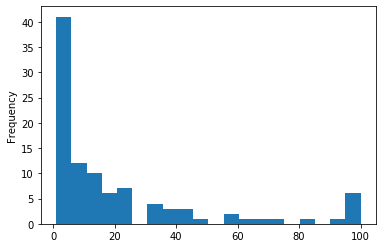

In [118]:
num_ven = toronto_venues.groupby("Postal code").count()["Venue"]
num_ven.plot(kind="hist", bins=20)

Next, we use One Hot Encoding for all the different categories. 

In [173]:
TO_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
TO_onehot.set_index(toronto_venues['Postal code'], inplace = True)
TO_onehot.head()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Postal code,,,,,,,,,,,,,,,,,,,,,
M1B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now I group the data frame by the postal code column and find the mean for each of the categories. 

In [217]:
TO_group = TO_onehot.groupby(TO_onehot.index).mean()
TO_group.head()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Postal code,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We use ```TO_group``` for clustering. Note that there are 100 postal codes as opposed to the original 103. This is presumably because no venues are in those 3 postal codes. 

In [245]:
kcluster = 5
kmeans = KMeans(n_clusters = kcluster, random_state = 0).fit(TO_group)
kmeans.labels_

array([1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 3, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [246]:
dataset2 = dataset.loc[dataset["Postal code"].isin(TO_group.index),:].reset_index(drop = True)
dataset2["Cluster"] = list(kmeans.labels_)
dataset2.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353,1
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,1
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711,1
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1


Now we have a cluster for each postal code. Let's plot the clusters as colors on the a map. 

In [247]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location = Davisville, zoom_start = 10)
x = np.arange(kcluster)
ys = [i + x + (i*x)**2 for i in range(kcluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, neigh, cluster in zip(dataset2['Latitude'], dataset2['Longitude'], dataset2['Postal code'], dataset2["Neighborhood"], dataset2['Cluster']):
    label = folium.Popup(str(neigh) + ' ' + str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see on the map almost all the district group together in cluster 1. I also tried allowing more clusters but it did not change the over all image—many districts simply have very similar venues. 